In [1]:
from google.colab import files
import os
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"memovdg","key":"447e8ce1038625b724217bc6fe5103df"}'}

In [0]:
#Creating the directory to save the data
! mkdir ~/.kaggle
#Copy the access
! cp kaggle.json ~/.kaggle/
#Give it permission
! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list //List the data sets

In [3]:
#Donwload and unzip the data
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip
! unzip chest_xray.zip

 99% 1.14G/1.15G [00:23<00:00, 44.0MB/s]
100% 1.15G/1.15G [00:23<00:00, 52.2MB/s]
Archive:  chest-xray-pneumonia.zip
  inflating: chest_xray.zip          
Archive:  chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/tes

In [0]:
#Setting the directories

train_dir = './chest_xray/train'
test_dir = './chest_xray/test'
val_dir = './chest_xray/val'

X-RAY NORMAL CHEST


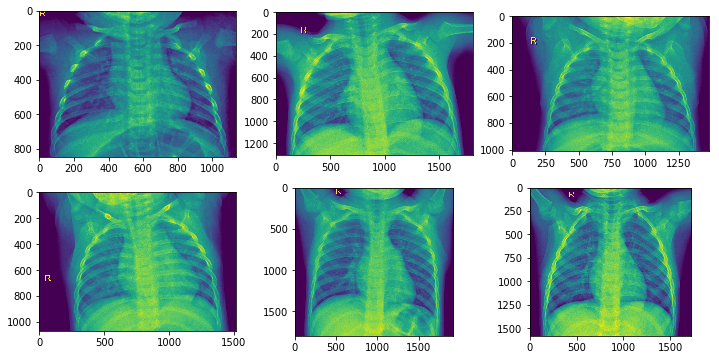

In [5]:
#Ploting some images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12,6))

  for file in os.listdir(path):
    if file.endswith('jpeg'):
      if amount == max_images:
        break
      
      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount +=1

#Presentig the data
print('X-RAY NORMAL CHEST')
plot_images(train_dir + '/NORMAL')

X_RAY PNEUMONIA CHEST


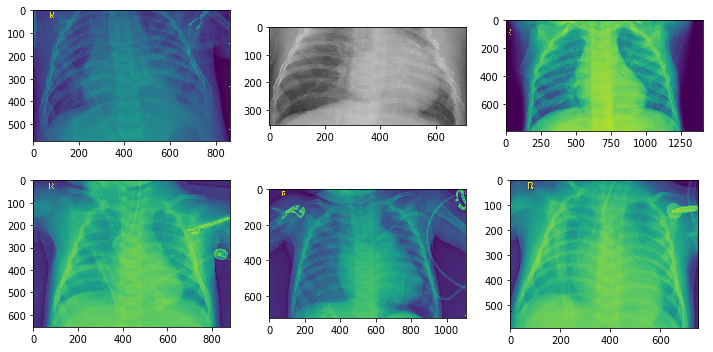

In [6]:
print('X_RAY PNEUMONIA CHEST')
plot_images(train_dir + '/PNEUMONIA')

In [7]:
import keras
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import ImageDataGenerator

#Parameters for data augmentation
rescale = 1./255.0
target_size = (150,150)
batch_size = 64
class_mode = 'categorical'

#Creating data augmentation in the training data set
#for train set we set shifts and other params
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
train_genimages = ImageDataGenerator(
    width_shift_range = 0.2,
    height_shift_range = 0.1,
    shear_range = 0.1,
    zoom_range = 0.1,
    horizontal_flip = True,
    rescale = rescale
)
#Set the directory for data augmentation
train_generator = train_genimages.flow_from_directory(
    train_dir,
    target_size = target_size,
    class_mode = class_mode,
    batch_size = batch_size
)

#For this two we only scale the images
# Test set
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=1
)

# Validation set
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size
)




Using TensorFlow backend.


Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [8]:
def get_model():
  base_model = InceptionV3(weights='imagenet', include_top=False)
  x = base_model.output
  x = keras.layers.GlobalAveragePooling2D()(x)
  x = keras.layers.Dense(1024, activation='relu')(x)
  x = keras.layers.BatchNormalization()(x)

  predictions = keras.layers.Dense(2, activation='softmax')(x)
  model = keras.models.Model(input=base_model.inputs, outputs = predictions)


  for layer in base_model.layers:
    layer.trainable = False

  model.summary()
  return model

model = get_model()









87916544/87910968 [==============================] - 3s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
___________________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=[<tf.Tenso...)`
  if __name__ == '__main__':


In [9]:
#Traininig the model 
model.compile(keras.optimizers.Adam(0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    verbose=1,
    validation_data=test_generator,
    validation_steps=len(test_generator)
)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/10
82/82 [==============================] - 106s 1s/step - loss: 0.4469 - acc: 0.8422 - val_loss: 2.8676 - val_acc: 0.5673
Epoch 2/10
82/82 [==============================] - 92s 1s/step - loss: 0.2527 - acc: 0.8962 - val_loss: 0.9252 - val_acc: 0.7276
Epoch 3/10
82/82 [==============================] - 92s 1s/step - loss: 0.2346 - acc: 0.9068 - val_loss: 1.3015 - val_acc: 0.6891
Epoch 4/10
82/82 [==============================] - 92s 1s/step - loss: 0.2261 - acc: 0.9103 - val_loss: 1.4816 - val_acc: 0.6378
Epoch 5/10
82/82 [==============================] - 93s 1s/step - loss: 0.2357 - acc: 0.9080 - val_loss: 2.3866 - val_acc: 0.6859
Epoch 6/10
82/82 [==============================] - 91s 1s/step - loss: 0.2449 - acc: 0.9002 - val_loss: 1.4557 - val_acc: 0.7131
Epoch 7/10
82/82 [==============================] - 90s 1s/step - loss: 0.2235 - acc: 0.9108 - val_loss: 1.5811 - val_acc: 0

In [10]:
result = model.evaluate_generator(validation_generator, steps=len(validation_generator), verbose = 1 )
print('Loss: ', result[0])
print('Accuracy: ', result[1])

1/1 [==============================] - 1s 705ms/step
Loss:  1.700568437576294
Accuracy:  0.6875


In [18]:
#Validation
y_prediction = []
y_validation = []

for i in range(0, len(validation_generator)):
  y_img, y_valid = validation_generator[i]
  y_valid = y_valid.argmax(axis=-1)

  y_validation.append(y_valid)
  y_pred = model.predict(y_img)
  y_pred = y_pred.argmax(axis = -1)
  y_prediction.append(y_pred)

  print(y_prediction)

[array([0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1])]


In [29]:
#Display images
print(y_pred)
def display_images(path, label, y_pred):
  amount = 0
  fig = plt.figure(figsize=(18,8))

  for file in os.listdir(path):
    if file.endswith('.jpeg'):
      if amount == 5:
        break
      
      true_label = ''

      if y_pred[amount] == 0:
        true_label = 'NORMAL'
      if y_pred[amount] == 1:
        true_label = 'PNEUMONIA'

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(241+amount)

      plt.title('PREDICTION : {}, TRUE VALIDATION :{}'.format(label, true_label))
      imgplot = plt.imshow(img)

      amount +=1


[0 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1]


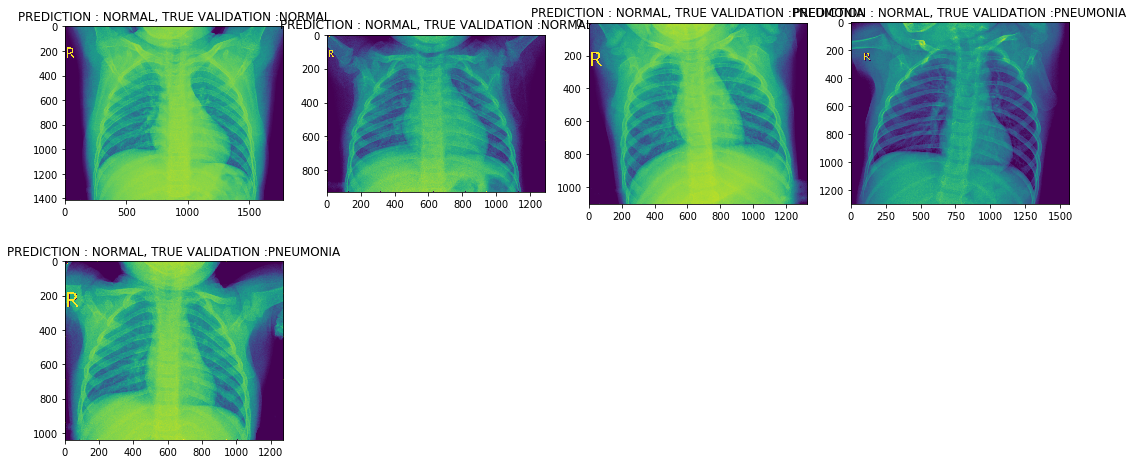

In [30]:
display_images('./chest_xray/val/NORMAL', 'NORMAL', y_pred)

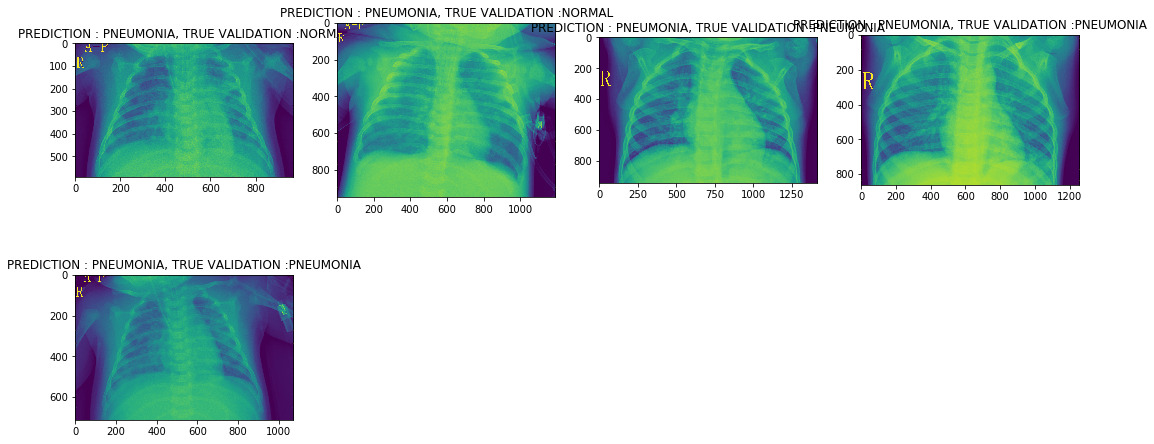

In [31]:
display_images('./chest_xray/val/PNEUMONIA', 'PNEUMONIA', y_pred)